# Notebook 3: FFJORD em MNIST Completo

Este notebook implementa FFJORD (Free-form Jacobian of Reversible Dynamics) para treinar em MNIST completo usando Hutchinson trace estimator.

## Objetivos:
1. Implementar FFJORD com Hutchinson trace estimator
2. Treinar em MNIST completo (784 dimensões) com preprocessing adequado
3. Avaliar log-likelihood e bits per dimension
4. Gerar amostras e visualizar resultados
5. Analisar trade-offs computacionais (NFEs, tempo de treinamento)
6. Comparar com RealNVP baseline (opcional)


In [ ]:
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('..')
import time
import numpy as np
import torch
import torch.optim as optim
from src.models.ffjord import FFJORD
from src.models.vector_field import VectorFieldMNIST
from src.utils.datasets import MNISTComplete, get_dataloader
from src.utils.training import train_ffjord, train_realnvp
from zuko.flows import RealNVP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Directories for saving figures and checkpoints
FIGURES_DIR = '../results/figures'
CHECKPOINTS_DIR = '../results/checkpoints'
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

# Dataset name for file naming
DATASET_NAME = 'mnist'


Using device: cuda


## 1. Carregar Dataset MNIST com Preprocessing

MNIST requer preprocessing adequado para flows:
- **Dequantization**: Adiciona ruído uniforme para tornar dados contínuos
- **Logit transform**: Transforma [0, 1] para R usando logit(x) = log(x / (1-x))


Carregando MNIST completo...
Training samples: 60000
Test samples: 10000
Feature dimension: 784
Figure saved to: ../results/figures/03_mnist_ffjord_samples.png


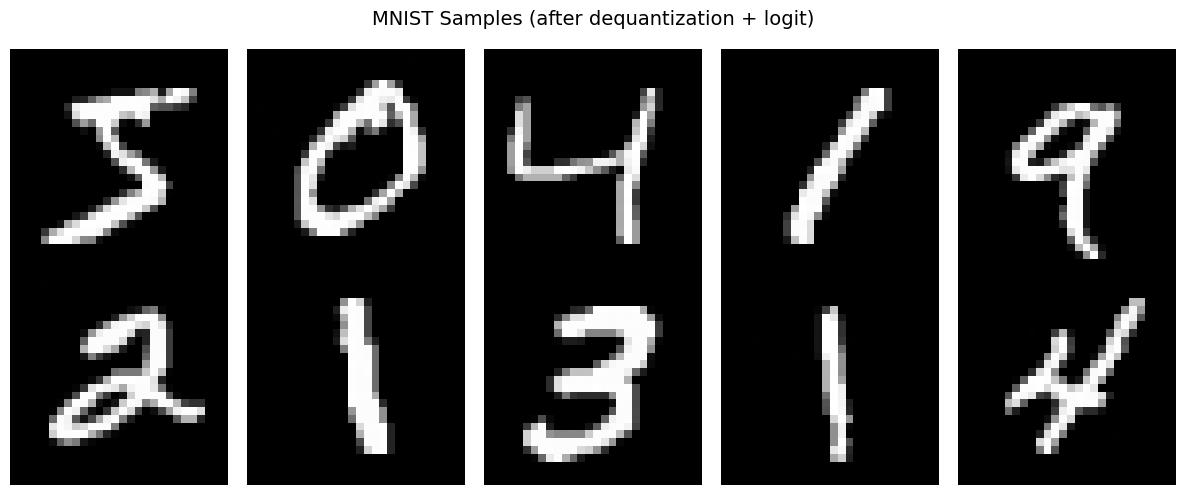

In [ ]:
# Carregar MNIST completo com preprocessing
print("Carregando MNIST completo...")
train_dataset = MNISTComplete(train=True)
test_dataset = MNISTComplete(train=False)

train_loader = get_dataloader(train_dataset, batch_size=256, shuffle=True)
test_loader = get_dataloader(test_dataset, batch_size=256, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Feature dimension: {train_dataset[0].shape[0]}")

# Visualizar algumas amostras (após preprocessing)
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    row, col = i // 5, i % 5
    sample = train_dataset[i].cpu().numpy()
    # Inverter logit transform para visualização
    # x = sigmoid(sample) = 1 / (1 + exp(-sample))
    sample_vis = 1 / (1 + np.exp(-sample))
    sample_vis = sample_vis.reshape(28, 28)
    axes[row, col].imshow(sample_vis, cmap='gray')
    axes[row, col].axis('off')
plt.suptitle('MNIST Samples (after dequantization + logit)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'03_{DATASET_NAME}_ffjord_samples.png'), dpi=300, bbox_inches='tight')
print(f"Figure saved to: {os.path.join(FIGURES_DIR, f'03_{DATASET_NAME}_ffjord_samples.png')}")
plt.show()


## 2. Criar e Treinar FFJORD

FFJORD usa Hutchinson trace estimator para escalar a dimensões altas:
- **Trace exato**: O(d²) - inviável para 784 dim
- **Hutchinson**: O(d) - escalável!

Hiperparâmetros recomendados (do PDF):
- Learning rate: 1e-4
- Batch size: 128-256
- Regularização KE: λ_KE = 0.01
- Warm-up: 5 epochs
- Epochs: 50-100


In [ ]:
# Criar Vector Field
vf = VectorFieldMNIST(
    features=784,
    channels=[512, 512, 512],
    time_embed_dim=32
).to(device)

# Criar FFJORD
ffjord = FFJORD(
    vector_field=vf,
    num_samples=1,
    distribution='rademacher'
).to(device)

# Otimizador com learning rate menor
optimizer = optim.Adam(ffjord.parameters(), lr=1e-4)

# Treinar FFJORD
print("Treinando FFJORD em MNIST completo...")
start_time = time.time()

train_ffjord(
    ffjord,
    train_loader,
    optimizer,
    device,
    n_epochs=50,  # Começar com 50, pode aumentar
    lambda_ke=0.01,  # Regularização de energia cinética
    warmup_epochs=5
)

train_time = time.time() - start_time
print(f"\nTempo de treinamento: {train_time / 60:.2f} minutos")

# Salvar checkpoint
checkpoint_path = os.path.join(CHECKPOINTS_DIR, f'03__{DATASET_NAME}_ffjord.pt')
torch.save(ffjord.state_dict(), checkpoint_path)
print(f"Checkpoint saved to: {checkpoint_path}")


Treinando FFJORD em MNIST completo...


Epoch 1/50:   0%|          | 0/235 [00:22<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 5.91 GiB of which 314.25 MiB is free. Including non-PyTorch memory, this process has 5.56 GiB memory in use. Of the allocated memory 4.66 GiB is allocated by PyTorch, and 784.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## 3. Avaliar Modelo

Calcular log-likelihood e bits per dimension no conjunto de teste.


In [ ]:
def bits_per_dim(log_prob, n_dims):
    """Calcular bits per dimension."""
    return -log_prob / (n_dims * np.log(2))


# Carregar modelo do checkpoint
checkpoint_path = os.path.join(CHECKPOINTS_DIR, f'03__{DATASET_NAME}_ffjord.pt')
vf = VectorFieldMNIST(
    features=784,
    channels=[512, 512, 512],
    time_embed_dim=32
).to(device)
ffjord = FFJORD(
    vector_field=vf,
    num_samples=1,
    distribution='rademacher'
).to(device)
ffjord.load_state_dict(torch.load(checkpoint_path, map_location=device))
ffjord.eval()

# Avaliar no conjunto de teste
test_log_probs = []
test_bpd = []

with torch.no_grad():
    for batch in test_loader:
        if isinstance(batch, (list, tuple)):
            x = batch[0].to(device)
        else:
            x = batch.to(device)

        log_prob = ffjord.log_prob(x)
        bpd = bits_per_dim(log_prob, n_dims=784)

        test_log_probs.append(log_prob.cpu().numpy())
        test_bpd.append(bpd.cpu().numpy())

test_log_probs = np.concatenate(test_log_probs)
test_bpd = np.concatenate(test_bpd)

print(f"Test Log-likelihood: {test_log_probs.mean():.4f} ± {test_log_probs.std():.4f}")
print(f"Test Bits per Dimension: {test_bpd.mean():.4f} ± {test_bpd.std():.4f}")

# Histograma de bits per dimension
plt.figure(figsize=(10, 6))
plt.hist(test_bpd, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(test_bpd.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {test_bpd.mean():.4f}')
plt.xlabel('Bits per Dimension', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Bits per Dimension (Test Set)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'03_{DATASET_NAME}_ffjord_bits_per_dim.png'), dpi=300, bbox_inches='tight')
print(f"Figure saved to: {os.path.join(FIGURES_DIR, f'03_{DATASET_NAME}_ffjord_bits_per_dim.png')}")
plt.show()


## 4. Gerar Amostras

Gerar novas amostras a partir do modelo treinado.


In [ ]:
# Carregar modelo do checkpoint
checkpoint_path = os.path.join(CHECKPOINTS_DIR, f'03__{DATASET_NAME}_ffjord.pt')
vf = VectorFieldMNIST(
    features=784,
    channels=[512, 512, 512],
    time_embed_dim=32
).to(device)
ffjord = FFJORD(
    vector_field=vf,
    num_samples=1,
    distribution='rademacher'
).to(device)
ffjord.load_state_dict(torch.load(checkpoint_path, map_location=device))
ffjord.eval()

# Gerar amostras
print("Gerando amostras...")
start_time = time.time()
samples = ffjord.sample(64)  # Gerar 64 amostras
sample_time = time.time() - start_time

print(f"Tempo de geração (64 amostras): {sample_time:.2f} segundos")
print(f"Tempo por amostra: {sample_time/64:.3f} segundos")

# Converter de logit space para [0, 1] para visualização
samples_vis = torch.sigmoid(samples).cpu().numpy()

# Visualizar amostras
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i in range(64):
    row, col = i // 8, i % 8
    img = samples_vis[i].reshape(28, 28)
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].axis('off')
plt.suptitle('FFJORD Generated Samples', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'03_{DATASET_NAME}_ffjord_generated_samples.png'), dpi=300, bbox_inches='tight')
print(f"Figure saved to: {os.path.join(FIGURES_DIR, f'03_{DATASET_NAME}_ffjord_generated_samples.png')}")
plt.show()


## 5. Análise de NFEs (Number of Function Evaluations)

Analisar quantas avaliações da função são necessárias durante a integração ODE.


In [ ]:
# Carregar modelo do checkpoint
checkpoint_path = os.path.join(CHECKPOINTS_DIR, f'03__{DATASET_NAME}_ffjord.pt')
vf = VectorFieldMNIST(
    features=784,
    channels=[512, 512, 512],
    time_embed_dim=32
).to(device)
ffjord = FFJORD(
    vector_field=vf,
    num_samples=1,
    distribution='rademacher'
).to(device)
ffjord.load_state_dict(torch.load(checkpoint_path, map_location=device))
ffjord.eval()

# Contar NFEs durante forward pass
from src.utils.training import CountingVectorField2D


def count_nfe_ffjord(model, x, reverse=False):
    """Contar NFEs para FFJORD."""
    counting_vf = CountingVectorField2D(model.vf)
    original_vf = model.vf
    model.vf = counting_vf

    with torch.no_grad():
        _, _ = model.forward(x, reverse=reverse)

    nfe = counting_vf.nfe
    model.vf = original_vf
    return nfe


# Testar em um batch pequeno
test_batch = next(iter(test_loader))
if isinstance(test_batch, (list, tuple)):
    x_test = test_batch[0][:10].to(device)
else:
    x_test = test_batch[:10].to(device)

nfe_forward = count_nfe_ffjord(ffjord, x_test, reverse=False)
nfe_reverse = count_nfe_ffjord(ffjord, x_test, reverse=True)

print(f"NFEs (forward, x -> z): {nfe_forward}")
print(f"NFEs (reverse, z -> x): {nfe_reverse}")
print(
    "NFEs médio por amostra: "
    f"{(nfe_forward + nfe_reverse) / 2 / len(x_test):.1f}"
)

# Comparar com diferentes tolerâncias
print("\n=== Comparação de Tolerâncias ===")

## 6. Comparação com RealNVP (Opcional)

Comparar FFJORD com RealNVP baseline para entender trade-offs.


In [ ]:
# Criar e treinar RealNVP para comparação
print("Treinando RealNVP para comparação...")
realnvp = RealNVP(
    features=784,
    transforms=4,
    hidden_features=[512, 512]
).to(device)

optimizer_rnvp = optim.Adam(realnvp.parameters(), lr=1e-4)

start_time = time.time()
train_realnvp(realnvp, train_loader, optimizer_rnvp, device, n_epochs=50)
train_time_rnvp = time.time() - start_time
print(f"Tempo de treinamento RealNVP: {train_time_rnvp/60:.2f} minutos")

# Salvar checkpoint
checkpoint_path = os.path.join(CHECKPOINTS_DIR, f'03__{DATASET_NAME}_realnvp.pt')
torch.save(realnvp.state_dict(), checkpoint_path)
print(f"Checkpoint saved to: {checkpoint_path}")

# Avaliar RealNVP
realnvp.eval()
test_log_probs_rnvp = []
test_bpd_rnvp = []

with torch.no_grad():
    for batch in test_loader:
        if isinstance(batch, (list, tuple)):
            x = batch[0].to(device)
        else:
            x = batch.to(device)

        dist = realnvp(None)
        log_prob = dist.log_prob(x)
        bpd = bits_per_dim(log_prob, n_dims=784)

        test_log_probs_rnvp.append(log_prob.cpu().numpy())
        test_bpd_rnvp.append(bpd.cpu().numpy())

test_log_probs_rnvp = np.concatenate(test_log_probs_rnvp)
test_bpd_rnvp = np.concatenate(test_bpd_rnvp)

print("\n=== Comparação ===")
print(f"FFJORD - Test BPD: {test_bpd.mean():.4f} ± {test_bpd.std():.4f}")
print(
    f"RealNVP - Test BPD: {test_bpd_rnvp.mean():.4f} ± "
    f"{test_bpd_rnvp.std():.4f}"
)
print(f"\nFFJORD - Train time: {train_time/60:.2f} min")
print(f"RealNVP - Train time: {train_time_rnvp/60:.2f} min")


In [ ]:
# Carregar modelos dos checkpoints
# FFJORD
checkpoint_path_ffjord = os.path.join(CHECKPOINTS_DIR, f'03__{DATASET_NAME}_ffjord.pt')
vf = VectorFieldMNIST(
    features=784,
    channels=[512, 512, 512],
    time_embed_dim=32
).to(device)
ffjord = FFJORD(
    vector_field=vf,
    num_samples=1,
    distribution='rademacher'
).to(device)
ffjord.load_state_dict(torch.load(checkpoint_path_ffjord, map_location=device))
ffjord.eval()

# RealNVP
checkpoint_path_rnvp = os.path.join(CHECKPOINTS_DIR, f'03__{DATASET_NAME}_realnvp.pt')
realnvp = RealNVP(
    features=784,
    transforms=4,
    hidden_features=[512, 512]
).to(device)
realnvp.load_state_dict(torch.load(checkpoint_path_rnvp, map_location=device))
realnvp.eval()

# Gerar amostras do FFJORD
start_time = time.time()
samples_ffjord = ffjord.sample(64)
sample_time_ffjord = time.time() - start_time
samples_vis = torch.sigmoid(samples_ffjord).cpu().numpy()

# Gerar amostras do RealNVP
start_time = time.time()
samples_rnvp = realnvp(None).sample((64,))
sample_time_rnvp = time.time() - start_time

samples_rnvp_vis = torch.sigmoid(samples_rnvp).cpu().numpy()

# Visualizar comparação
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    # FFJORD
    img_ffjord = samples_vis[i].reshape(28, 28)
    axes[0, i].imshow(img_ffjord, cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('FFJORD', fontsize=12)

    # RealNVP
    img_rnvp = samples_rnvp_vis[i].reshape(28, 28)
    axes[1, i].imshow(img_rnvp, cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('RealNVP', fontsize=12)

plt.suptitle('Sample Comparison: FFJORD vs RealNVP', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'03_{DATASET_NAME}_comparison_ffjord_realnvp.png'), dpi=300, bbox_inches='tight')
print(f"Figure saved to: {os.path.join(FIGURES_DIR, f'03_{DATASET_NAME}_comparison_ffjord_realnvp.png')}")
plt.show()


## 7. Análise e Conclusões

### Trade-offs Computacionais

**FFJORD:**
- ✅ Escalável a dimensões altas (O(d) com Hutchinson)
- ✅ Expressivo (transformações contínuas)
- ❌ Mais lento que discrete flows (integração ODE)
- ❌ Requer mais memória (adjoint method)

**RealNVP:**
- ✅ Rápido (forward pass direto)
- ✅ Eficiente em memória
- ❌ Menos expressivo (transformações discretas)
- ❌ Requer arquitetura cuidadosa (coupling layers)

### Por que Hutchinson é essencial?

- **Trace exato**: O(d²) = O(784²) = O(614,656) operações
- **Hutchinson**: O(d) = O(784) operações
- **Speedup**: ~784x mais rápido!

### Preparação para Flow Matching

FFJORD é um precursor conceitual para Flow Matching:
- Ambos usam ODEs contínuas
- Ambos aprendem vector fields
- Flow Matching melhora: treinamento mais estável, sem necessidade de trace
